In [108]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
# Load the USArrests dataset
df = pd.read_csv("USArrests.csv")
df[df.columns[-4:]] = df[df.columns[-4:]].astype(float)
# Get the number of observations (rows) and variables (columns) in the data
num_observations = df.shape[0]
num_variables = df.shape[1]


print("Number of Observations:", num_observations)
print("Number of Variables:", num_variables)

Number of Observations: 50
Number of Variables: 5


In [109]:
df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236.0,58.0,21.2
1,Alaska,10.0,263.0,48.0,44.5
2,Arizona,8.1,294.0,80.0,31.0
3,Arkansas,8.8,190.0,50.0,19.5
4,California,9.0,276.0,91.0,40.6


We have five variables: City,Murder,Assault,UrbanPop,Rape
Quick look at the data shows no missing values, however the City column is actually listing states.

In [110]:
df = df.rename(columns={'City': 'State'})


            Murder   Assault  UrbanPop      Rape
Murder    1.000000  0.801873  0.069573  0.563579
Assault   0.801873  1.000000  0.258872  0.665241
UrbanPop  0.069573  0.258872  1.000000  0.411341
Rape      0.563579  0.665241  0.411341  1.000000


C:\Users\Mark\AppData\Local\Temp\ipykernel_19284\2002970458.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


<AxesSubplot: >

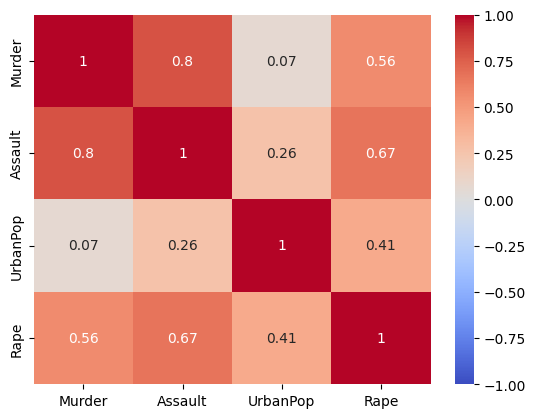

In [111]:
correlation_matrix = df.corr()
print(correlation_matrix)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

From this we can infer that murders happen less often than assaults and assaults less often than rapes, due to the relationships between urban population and murder, assault, rape.
There is a strong correlatino between rape and assault, as a rape is inherently an assault. 
However, it may not always be an assault depending how the data was harvested, it could be murder or an assault as well - hence not all rapes being assaults.

There aren't many variables to look at here but we will run a PCA anyway.
PCA is sensitive to the scale of data so we will do that first:

In [112]:
df = df.drop(columns="State")

In [113]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_data_df = pd.DataFrame(scaled_data, columns=df.columns)


In [114]:
pca = PCA(n_components=4)
pca_results = pca.fit_transform(scaled_data_df)
explained_variance = pca.explained_variance_ratio_

print("Explained Variance:", explained_variance)
for i in explained_variance:
    ratio = (i/explained_variance.sum())*100
    print(ratio)


Explained Variance: [0.62006039 0.24744129 0.0891408  0.04335752]
62.00603947873735
24.74412881349603
8.91407951452073
4.335752193245882


We can clearly see that PCA 1 and PCA 2 are responsible for 86% of the variance in the data set.


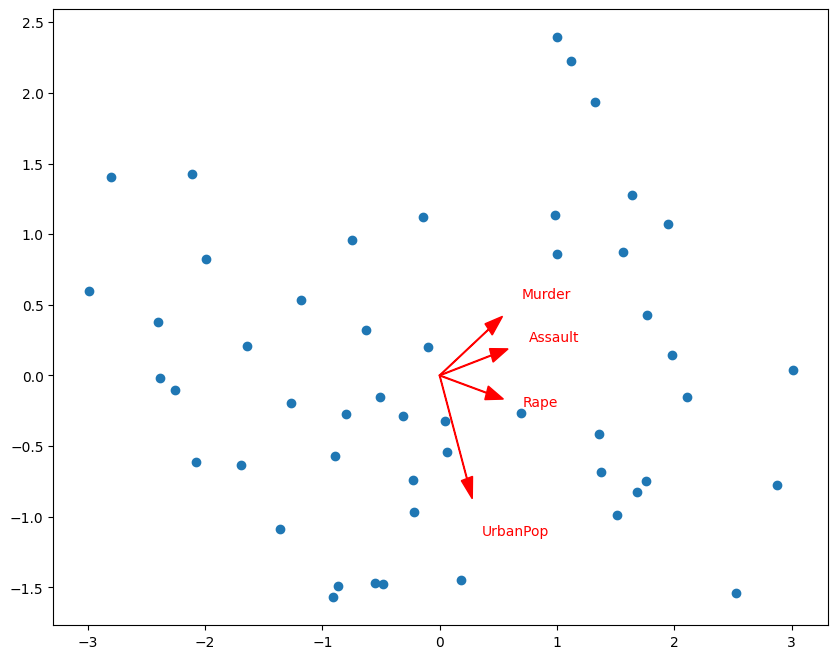

In [115]:
# Create a biplot of the first two principal components
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(pca_results[:, 0], pca_results[:, 1])

for i, feature in enumerate(df.columns):
    ax.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], color='r',
             width=0.005, head_width=0.1, length_includes_head=True)
    ax.text(pca.components_[0, i] * 1.3, pca.components_[1, i] * 1.3, feature, color='r')


The above graph show that Murder, assault and rape all more or less trend in the same direction.
Urban population is a slightly weaker correlation.

In [116]:
# Apply K-means clustering to the standardized data
kmeans = KMeans(n_clusters=3)
kmeans_labels = kmeans.fit_predict(scaled_data_df)


C:\Users\Mark\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [117]:
# Apply agglomerative clustering to the standardized data
aggclustering = AgglomerativeClustering(n_clusters=3)
aggclustering_labels = aggclustering.fit_predict(scaled_data_df)


In [118]:
# Print the clustering labels for the first five states
print('K-means clustering labels: ', kmeans_labels[:5])
print('Agglomerative clustering labels: ', aggclustering_labels[:5])

K-means clustering labels:  [1 1 1 0 1]
Agglomerative clustering labels:  [0 0 0 1 0]


In [119]:
Z = linkage(scaled_data_df, 'ward')

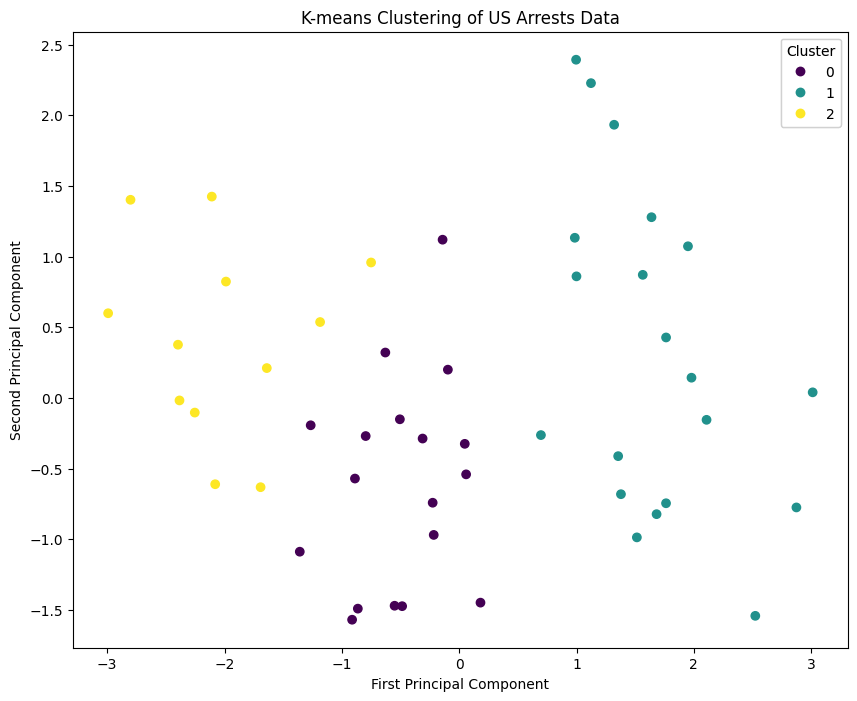

In [120]:
# Create a scatter plot of the first two principal components with data points colored by cluster assignment
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(pca_results[:, 0], pca_results[:, 1], c=kmeans_labels)

# Add a colorbar to the plot
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Cluster")
ax.add_artist(legend1)

# Set labels and title
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_title('K-means Clustering of US Arrests Data')

# Show the plot
plt.show()

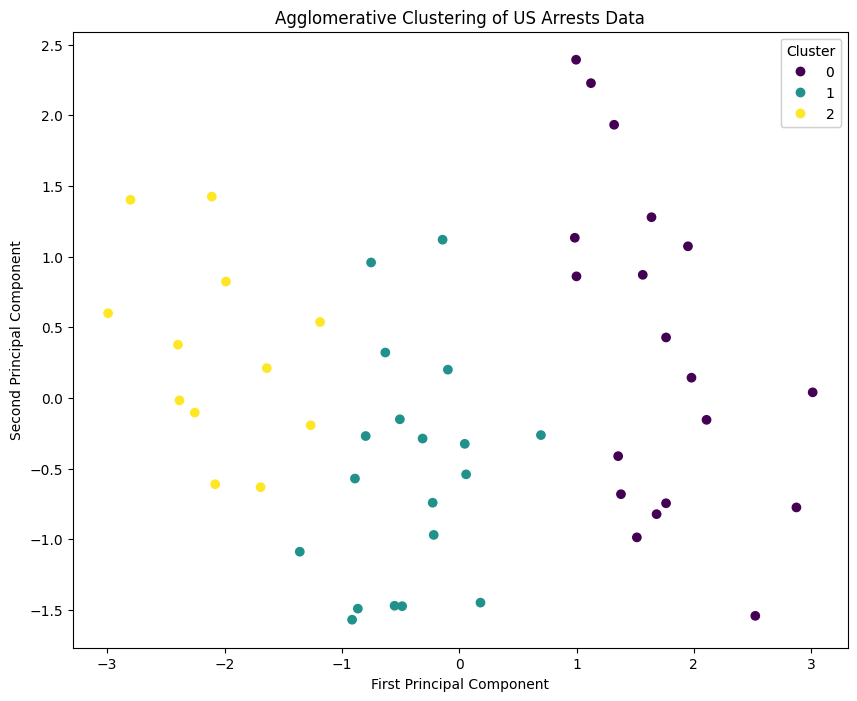

In [121]:
# Create a scatter plot of the first two principal components with data points colored by cluster assignment
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(pca_results[:, 0], pca_results[:, 1], c=aggclustering_labels)

# Add a colorbar to the plot
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Cluster")
ax.add_artist(legend1)

# Set labels and title
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_title('Agglomerative Clustering of US Arrests Data')

# Show the plot
plt.show()

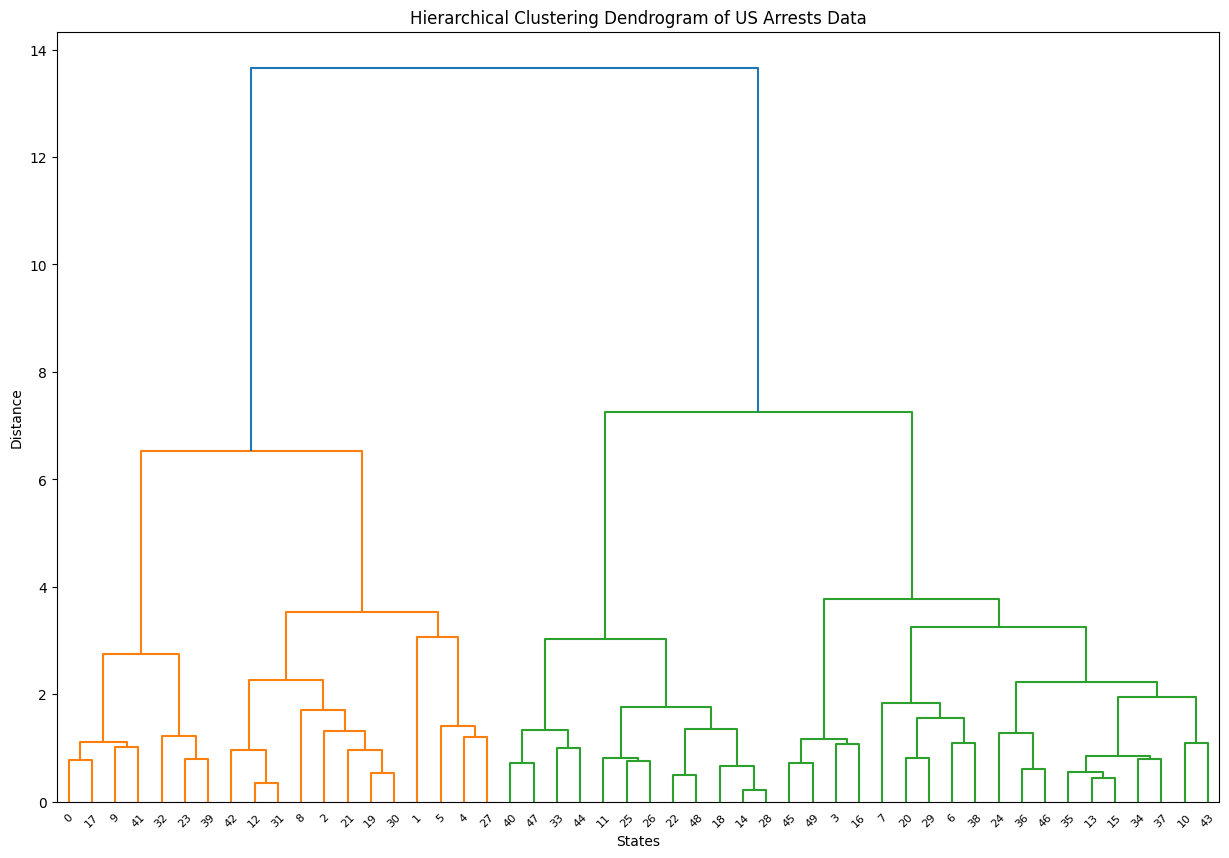

In [122]:
# Plot a dendrogram of the hierarchical clustering results
fig, ax = plt.subplots(figsize=(15, 10))
dendrogram(Z, labels=df.index)

# Set labels and title
ax.set_xlabel('States')
ax.set_ylabel('Distance')
ax.set_title('Hierarchical Clustering Dendrogram of US Arrests Data')

# Rotate the x-axis labels for better visibility
plt.setp(ax.get_xticklabels(), rotation=45)

# Show the plot
plt.show()